## Introducing Agentic Decisions into RAG Pipelines

### Overview

This demo expands a basic RAG (Retrieval-Augmented Generation) pipeline to include **agentic decision-making**. The system dynamically decides whether to rely on retrieved documents or perform **live web research** depending on the quality of retrieved information.

In [39]:
import os 
from typing import List, Dict

# LLM related
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage 
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# RAG related
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

# Tools related
from langchain_core.tools import tool
from tavily import TavilyClient

# Graph related
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import MessagesState
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()

True

### Offline Preparing Data for RAG

#### 1. Documents Processing

In [40]:
file_path = "the-era-of-experience.pdf"
loader = PyPDFLoader(file_path)

pages = []
async for page in loader.alazy_load():
    pages.append(page)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(pages)

#### 2. Vector Representation

In [41]:
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large"
)

#### 3. Vector Store

In [42]:
vector_store = Chroma(
    collection_name="demo",
    embedding_function=embeddings_fn
)
_ = vector_store.add_documents(documents=all_splits)

### Define State Schema

A custom state is defined including:

- `search_required`: a yes/no flag determining whether a web search is necessary.
- Other standard RAG fields (messages, question, etc.).

In [43]:
class State(MessagesState):
    question: str
    documents: List[Document]
    search_required: str = "NO"
    answer: str

### RAG Nodes

#### 1. Retrieve Node

- Performs a similarity search using the vector store.
- Retrieves documents related to the input question and stores them in state.

In [44]:
def retrieve(state: State):
    question = state["question"]
    retrieved_docs = vector_store.similarity_search(question)
    return {"documents": retrieved_docs}

#### 2. Augment Node

- If web search is not required, retrieved documents are passed to the LLM for direct answering.

In [45]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)
    
    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", "Use the following pieces of retrieved context to answer the question. "
                "If you don't know the answer, just say that you don't know. " 
                "Use three sentences maximum and keep the answer concise. "
                "\n# Question: \n-> {question} "
                "\n# Context: \n-> {context} "
                "\n# Answer: "),
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

#### 3. Generate Node

- Final output generation based on the selected source of context.

In [46]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

def generate(state: State):
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

### Evaluator Node

- Uses an LLM chain with a prompt asking:
    - *"Based on retrieved documents, is a web search required? Answer 'yes' or 'no'."*
- The LLM's response sets the `search_required` field.

In [47]:
def evaluator(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)
    
    template = ChatPromptTemplate([
        ("system", "You are an assistant for evaluating context."),
        ("human", "Use the following pieces of retrieved context to determine if an " 
                  "additional search is required. If the context is relevant to the " 
                  "question, your response should be 'NO', i.e. no need for search. "
                  "If the context is not relevant, say 'YES', i.e. search the web for an answer. " 
                  "Don't explain anything, if it's to search the web, say YES, otherwise, NO. "
                  "\n# Question: \n-> {question} "
                  "\n# Context: \n-> {context} "
                  "\n# Answer: "),
    ])

    chain = template | llm | StrOutputParser()

    search_required = chain.invoke(
        {"context": docs_content, "question": question}
    )

    return {"search_required": search_required}
    

### Search Node

In [48]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(question)
    return response

llm_with_tools = llm.bind_tools([web_search])

search = ToolNode([web_search])

### Researcher Node

- If web search is needed, the researcher node uses Tavily’s web search tool.
- Searches the web and updates messages with search results.

In [49]:
def researcher(state: State):
    question = state["question"]
    messages = state["messages"]
    if not messages:
        human_message = HumanMessage(
            "Conduct a web research to findout the answer to the following question: "
            f"```{question}```"
        )
        messages = [human_message]
    
    ai_message = llm_with_tools.invoke(messages)
    messages.append(ai_message)
    return {"messages": messages, "answer": ai_message.content}

### Router

#### Move to Local RAG

In [50]:
def rag_router(state: State):
    search_required = state["search_required"]
    if search_required.lower() == "yes":
        return "researcher"

    return "augment"

#### Move to Web Search

In [51]:
def tool_router(state: State):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "web_search"

    return END

### Agentic RAG Workflow

In [52]:
workflow = StateGraph(State)

workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)
workflow.add_node("evaluator", evaluator)
workflow.add_node("researcher", researcher)
workflow.add_node("web_search", search)

# START -> retrieve
workflow.add_edge(START, "retrieve")

# retrieve -> evaluator
workflow.add_edge("retrieve", "evaluator")

# evaluator -> augment or researcher
workflow.add_conditional_edges(
    source="evaluator", 
    path=rag_router, 
    path_map=["augment", "researcher"]
)

# ############ PATH 1: Local RAG #################
# augment -> generate
workflow.add_edge("augment", "generate")

# generate -> END
workflow.add_edge("generate", END)

# ############ PATH 2: Web Search #################
# researcher -> web_search or END
workflow.add_conditional_edges(
    source="researcher", 
    path=tool_router, 
    path_map=["web_search", END]
)

# web_search -> researcher
workflow.add_edge("web_search", "researcher")

graph = workflow.compile()

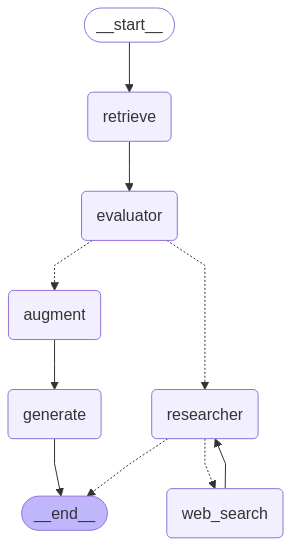

In [61]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

### Execution

#### Path 1: Web Search

In [54]:
output = graph.invoke(
    input={"question": "How many eras for deep learning history?"},
)

In [55]:
output["search_required"]

'YES'

In [56]:
output["answer"]

'The search did not yield a specific answer regarding the number of eras in deep learning history. However, it did provide several resources that discuss the evolution and timeline of deep learning. \n\nFrom the general knowledge on the topic, deep learning history can often be divided into several key eras:\n\n1. **Early Concepts (1940s-1980s)**: This era includes the development of the first neural networks and foundational theories.\n2. **The AI Winter (1980s-1990s)**: A period of reduced funding and interest in AI and neural networks due to unmet expectations.\n3. **Resurgence and Breakthroughs (2000s)**: Renewed interest in neural networks, particularly with the advent of more powerful computing resources and large datasets.\n4. **Modern Deep Learning (2010-Present)**: The current era characterized by significant advancements in deep learning techniques, applications, and widespread adoption in various fields.\n\nFor a more detailed exploration, you can refer to the following arti

In [57]:
for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

Conduct a web research to findout the answer to the following question: ```How many eras for deep learning history?```
================================== Ai Message ==================================
Tool Calls:
  web_search (call_Xqs4a09UuDsEJeNQqZcFMong)
 Call ID: call_Xqs4a09UuDsEJeNQqZcFMong
  Args:
    question: How many eras for deep learning history?
================================= Tool Message =================================
Name: web_search

{"query": "How many eras for deep learning history?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Brief History of Deep Learning from 1943-2019 [Timeline] - MLK", "url": "https://machinelearningknowledge.ai/brief-history-of-deep-learning/", "content": "Deep Learning Yet it will lay the foundation for artificial neural network & deep learning. Sepp Hochreiter identifies the problem of vanishing gradient which can make 

#### Path 2: Local RAG

In [58]:
output = graph.invoke(
    input={"question": "What's the difference of Planning and Reasoning?"},
)

In [59]:
output["search_required"]

'NO'

In [60]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You are an assistant for question-answering tasks.
================================ Human Message =================================

Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. 
# Question: 
-> What's the difference of Planning and Reasoning? 
# Context: 
-> Planning and Reasoning
Will the era of experience change the way that agents plan and reason? Recently, there has been significant
progress using LLMs that can reason, or “think” with language [23, 14, 10], by following a chain of thought
before outputting a response [16]. Conceptually, LLMs can act as a universal computer [30]: an LLM can
append tokens into its own context, allowing it to execute arbitrary algorithms before outputting a final result.
In the era of human data, these reasoning methods have been 

### **Conclusion**
- **Dynamic decision-making** inside a RAG workflow.
- **Fallback to web search** when knowledge gaps are detected.
- **Agentic behavior**: LLM assesses context sufficiency and adapts.
- **Efficient resource use**: Web search is only triggered when necessary.
- Adding agentic decisions to RAG pipelines increases reliability and adaptability.
- Blending offline retrieval with online search creates more robust AI systems.
- This modular, decision-driven design is foundational for advanced AI agents.